In [2]:
""" This script demonstrates the use of a convolutional LSTM network.
This network is used to predict the next frame of an artificially
generated movie which contains moving squares.
"""
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt


In [4]:
# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')

In [5]:
# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

In [6]:
# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=300, validation_split=0.05)


Train on 950 samples, validate on 50 samples
Epoch 1/300
950/950 [==============================] - 124s 131ms/step - loss: 0.2372 - val_loss: 0.0482
Epoch 2/300
950/950 [==============================] - 113s 118ms/step - loss: 0.0171 - val_loss: 0.0079
Epoch 3/300
950/950 [==============================] - 113s 119ms/step - loss: 0.0136 - val_loss: 0.0074
Epoch 4/300
950/950 [==============================] - 114s 120ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 5/300
950/950 [==============================] - 114s 120ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/300
950/950 [==============================] - 113s 119ms/step - loss: 7.2015e-04 - val_loss: 9.3932e-04
Epoch 7/300
950/950 [==============================] - 129s 136ms/step - loss: 5.5693e-04 - val_loss: 5.9285e-04
Epoch 8/300
950/950 [==============================] - 113s 119ms/step - loss: 4.5563e-04 - val_loss: 5.3836e-04
Epoch 9/300
950/950 [==============================] - 113s 119ms/step - loss: 3.9083e-04 -

Epoch 73/300
950/950 [==============================] - 113s 119ms/step - loss: 4.5657e-05 - val_loss: 2.2733e-04
Epoch 74/300
950/950 [==============================] - 113s 119ms/step - loss: 4.5255e-05 - val_loss: 2.0894e-04
Epoch 75/300
950/950 [==============================] - 113s 119ms/step - loss: 4.3909e-05 - val_loss: 2.1609e-04
Epoch 76/300
950/950 [==============================] - 113s 119ms/step - loss: 4.3765e-05 - val_loss: 2.0726e-04
Epoch 77/300
950/950 [==============================] - 113s 119ms/step - loss: 4.2400e-05 - val_loss: 2.0240e-04
Epoch 78/300
950/950 [==============================] - 113s 119ms/step - loss: 4.2050e-05 - val_loss: 2.1313e-04
Epoch 79/300
950/950 [==============================] - 113s 119ms/step - loss: 4.1080e-05 - val_loss: 2.3321e-04
Epoch 80/300
950/950 [==============================] - 113s 119ms/step - loss: 4.1834e-05 - val_loss: 2.1875e-04
Epoch 81/300
950/950 [==============================] - 113s 119ms/step - loss: 4.0749e-

950/950 [==============================] - 113s 119ms/step - loss: 1.5579e-05 - val_loss: 2.4476e-04
Epoch 145/300
950/950 [==============================] - 113s 119ms/step - loss: 1.4859e-05 - val_loss: 2.3122e-04
Epoch 146/300
950/950 [==============================] - 113s 119ms/step - loss: 1.4539e-05 - val_loss: 2.5348e-04
Epoch 147/300
950/950 [==============================] - 113s 119ms/step - loss: 1.4124e-05 - val_loss: 2.3802e-04
Epoch 148/300
950/950 [==============================] - 113s 119ms/step - loss: 1.4360e-05 - val_loss: 2.3694e-04
Epoch 149/300
950/950 [==============================] - 113s 119ms/step - loss: 1.3842e-05 - val_loss: 2.4658e-04
Epoch 150/300
950/950 [==============================] - 113s 119ms/step - loss: 1.4746e-05 - val_loss: 2.3337e-04
Epoch 151/300
950/950 [==============================] - 113s 119ms/step - loss: 1.3448e-05 - val_loss: 2.5441e-04
Epoch 152/300
950/950 [==============================] - 113s 119ms/step - loss: 1.4385e-05 - 

950/950 [==============================] - 113s 119ms/step - loss: 7.7133e-06 - val_loss: 2.6147e-04
Epoch 216/300
950/950 [==============================] - 113s 119ms/step - loss: 6.5329e-06 - val_loss: 2.6715e-04
Epoch 217/300
950/950 [==============================] - 113s 119ms/step - loss: 6.8860e-06 - val_loss: 2.5448e-04
Epoch 218/300
950/950 [==============================] - 113s 119ms/step - loss: 7.1355e-06 - val_loss: 2.4780e-04
Epoch 219/300
950/950 [==============================] - 113s 119ms/step - loss: 6.4119e-06 - val_loss: 2.6043e-04
Epoch 220/300
950/950 [==============================] - 113s 119ms/step - loss: 6.8060e-06 - val_loss: 2.6597e-04
Epoch 221/300
950/950 [==============================] - 113s 119ms/step - loss: 6.2768e-06 - val_loss: 2.6726e-04
Epoch 222/300
950/950 [==============================] - 113s 119ms/step - loss: 6.5885e-06 - val_loss: 2.5869e-04
Epoch 223/300
950/950 [==============================] - 113s 119ms/step - loss: 6.5579e-06 - 

950/950 [==============================] - 113s 119ms/step - loss: 3.9946e-06 - val_loss: 2.7662e-04
Epoch 287/300
950/950 [==============================] - 113s 119ms/step - loss: 3.9949e-06 - val_loss: 2.7528e-04
Epoch 288/300
950/950 [==============================] - 113s 119ms/step - loss: 4.0100e-06 - val_loss: 2.7922e-04
Epoch 289/300
950/950 [==============================] - 113s 119ms/step - loss: 3.7912e-06 - val_loss: 2.7741e-04
Epoch 290/300
950/950 [==============================] - 113s 119ms/step - loss: 3.8555e-06 - val_loss: 2.6858e-04
Epoch 291/300
950/950 [==============================] - 113s 119ms/step - loss: 3.8201e-06 - val_loss: 2.8737e-04
Epoch 292/300
950/950 [==============================] - 113s 119ms/step - loss: 3.9332e-06 - val_loss: 2.8403e-04
Epoch 293/300
950/950 [==============================] - 113s 119ms/step - loss: 3.9035e-06 - val_loss: 2.8408e-04
Epoch 294/300
950/950 [==============================] - 113s 119ms/step - loss: 3.8826e-06 - 

In [7]:
# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


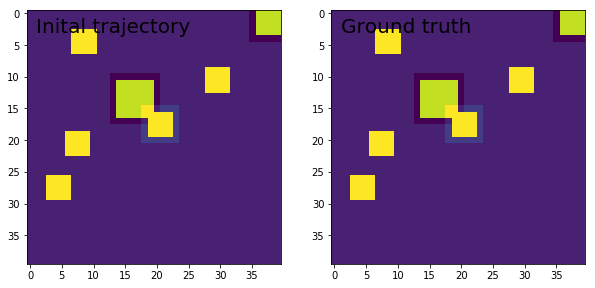

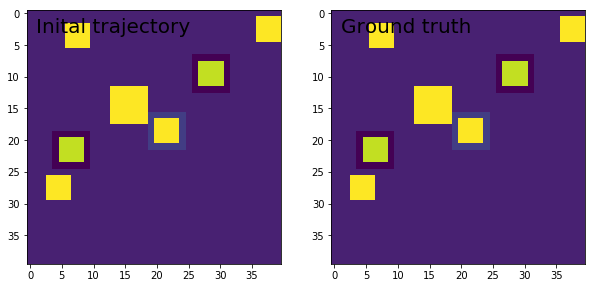

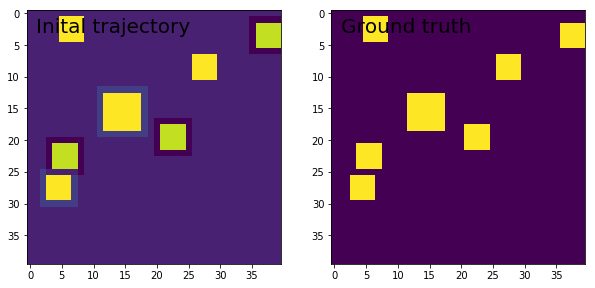

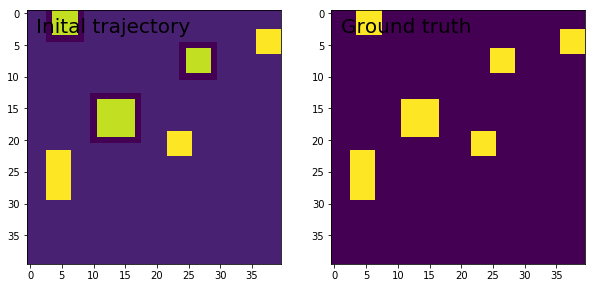

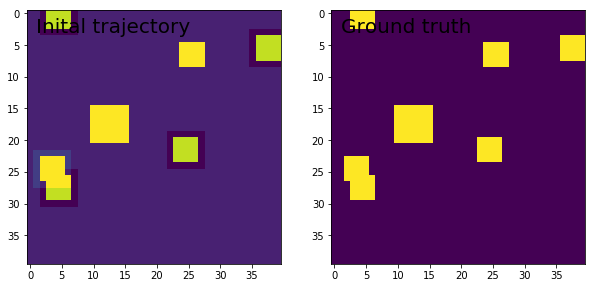

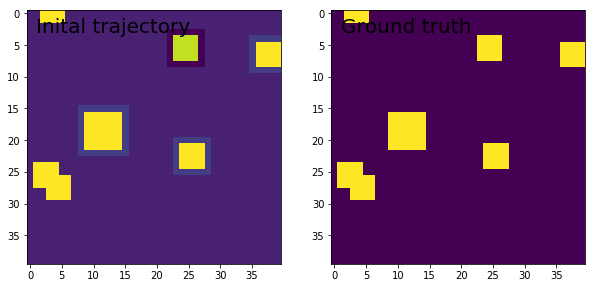

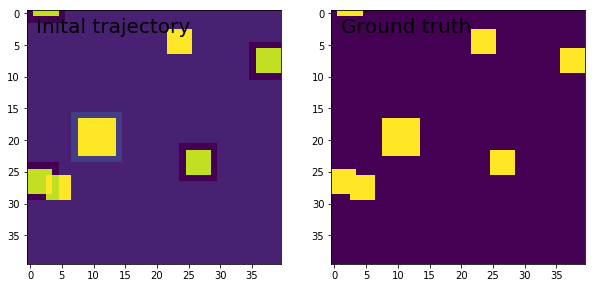

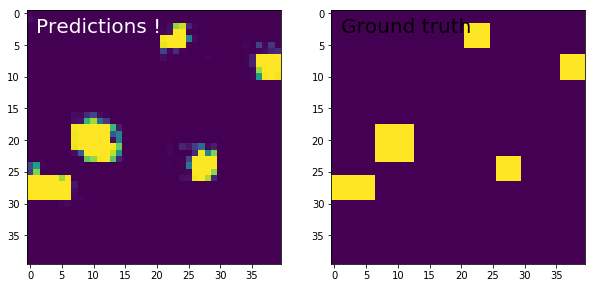

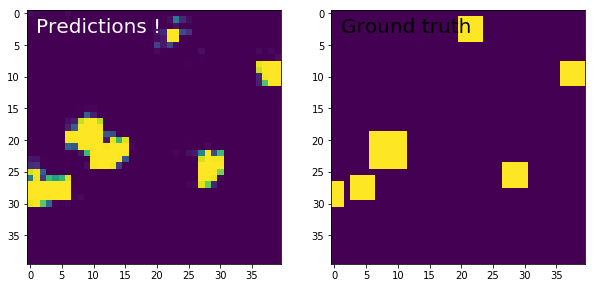

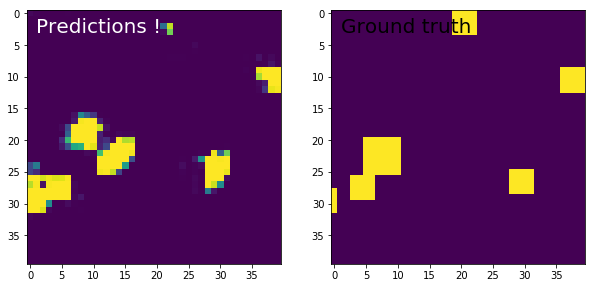

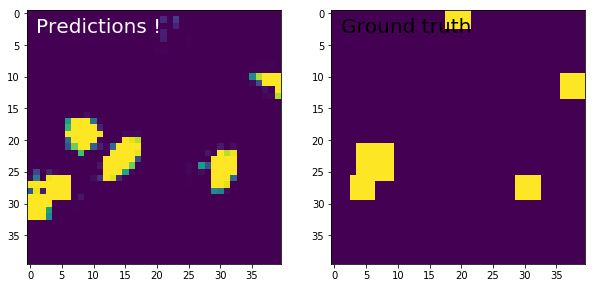

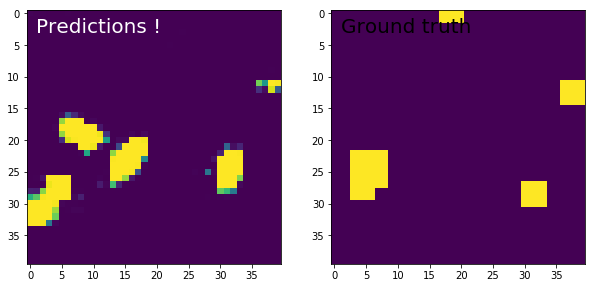

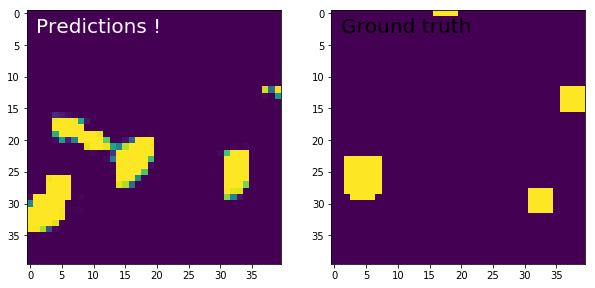

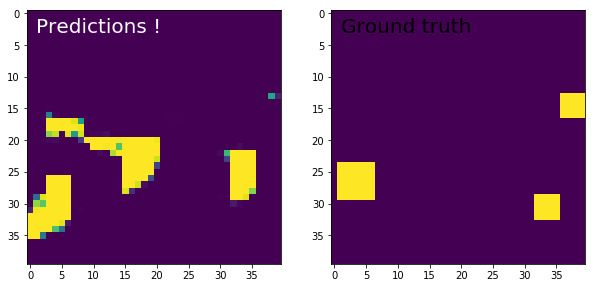

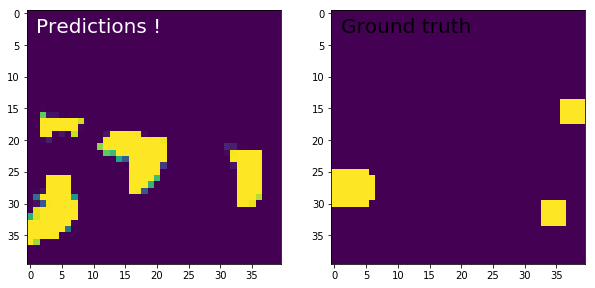

In [8]:
# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Inital trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))

In [9]:
seq.save('conv_lstm.h5')

In [10]:
noisy_movies.shape

(1200, 15, 40, 40, 1)

In [11]:
shifted_movies.shape

(1200, 15, 40, 40, 1)

In [12]:
noisy_movies[:1000].shape

(1000, 15, 40, 40, 1)

In [13]:
noisy_movies[which][:7, ::, ::, ::].shape

(7, 40, 40, 1)